In [1]:
import numpy as np
import math

In [2]:
!git clone https://github.com/HansBambel/multidim_conv.git

Cloning into 'multidim_conv'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 59 (delta 10), reused 12 (delta 3), pack-reused 34
Unpacking objects: 100% (59/59), 145.58 MiB | 14.45 MiB/s, done.


In [3]:
import pickle

with open('./multidim_conv/data/Wind_data_NL/dataset.pkl', 'rb') as f:
    data = pickle.load(f)

with open('./multidim_conv/data/Wind_data_NL/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [4]:
train_data = data['train']
test_data = data['test']
train_data.shape

(70128, 7, 6)

In [5]:
scaler

{'Features': ['Wind speed in 0.1m/s',
  'Wind direction in degrees (360 North, 90 East, 0 No wind)',
  'Temperature in 0.1C',
  'Dew Point in 0.1C',
  'Air Pressure in 0.1hpa',
  'Rain amount in 0.1mm'],
 'feature_min_train': array([ 0.000e+00,  0.000e+00, -1.950e+02, -2.170e+02,  9.681e+03,
        -1.000e+00]),
 'feature_max_train': array([  240.,   360.,   376.,   230., 10462.,   481.])}

In [6]:
# history_length is timestep of the historical window size
# predict_length is the prediction horizon
def build_data(data, x_len, y_len, gap=1):
    x = []
    y = []
    length = data.shape[0]
    for end_idx in range(x_len + y_len + gap, length):
        xtime = data[end_idx-y_len-x_len-gap:end_idx-y_len-gap]
        ytime = data[end_idx-y_len-gap:end_idx-gap]
        x.append(xtime)
        y.append(ytime)
    x = np.stack(x)
    y = np.stack(y)
    return x, y


"""Build data and train test split"""
def make_ready_data(data, train=True, temp=False, cos=False, gap=1):
    x_len = 10  # 10 historical time steps
    y_len = 1  # next step
    
    if temp:
        idx = 4
    else:
        idx = 1
        
    x, y = build_data(data[:, :, idx], x_len, y_len, gap) 
    
    """Convert the degrees into radians values and take the sine or cosine"""
    x, y = x.reshape(x.shape[0], 10, 7) * 2 * math.pi, y.reshape(y.shape[0], 7) *  2 * math.pi
    #if cos:
    xcos, ycos = np.cos(x), np.cos(y)
    #else:
    xsin, ysin = np.sin(x), np.sin(y)
    
    x = np.concatenate((xsin, xcos), axis=2)
    y = np.concatenate((ysin, ycos), axis=1)
    
    if train:
        xtrain = x[:60000]
        ytrain = y[:60000]
        xval = x[60000:]
        yval = y[60000:]
    
        return xtrain, xval, ytrain, yval
    else:
        return x, y

train_data = data['train']
test_data = data['test']

xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=1)
xtest, ytest = make_ready_data(test_data, train=False, gap=1)
xtrain.shape, xval.shape, ytrain.shape, yval.shape,xtest.shape, ytest.shape

((60000, 10, 14),
 (10116, 10, 14),
 (60000, 14),
 (10116, 14),
 (10860, 10, 14),
 (10860, 14))

In [7]:
import torch

def build_dl(xtrain, xval, xtest, ytrain, yval, ytest):
    """convert arrays to tensors"""
    batch_size = 32
    xtrain = torch.Tensor(xtrain).to(device)
    ytrain = torch.Tensor(ytrain).to(device)
    xval = torch.Tensor(xval).to(device)
    yval = torch.Tensor(yval).to(device)
    xtest = torch.Tensor(xtest).to(device)
    ytest = torch.Tensor(ytest).to(device)
    train_data = torch.utils.data.TensorDataset(xtrain, ytrain)
    train_iter = torch.utils.data.DataLoader(train_data, batch_size)
    val_data = torch.utils.data.TensorDataset(xval, yval)
    val_iter = torch.utils.data.DataLoader(val_data, batch_size)
    test_data = torch.utils.data.TensorDataset(xtest, ytest)
    test_iter = torch.utils.data.DataLoader(test_data, batch_size)
    
    return train_iter, val_iter, test_iter

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, ytrain, yval, ytest)

In [8]:
from torch import nn
from torch.autograd import Variable

class LSTM(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = 10
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size,
                            num_layers=num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))
        out = lstm_out[:, -1, :]
        out = self.linear(out)
    
        return out

In [9]:
"""Validation loop"""
def validate(model):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in val_iter:
            outputs = model(x)
            loss = loss_fn(outputs.cpu(), y.cpu())
            losses.append(loss)
    mean_loss = np.mean(losses)
    return mean_loss


"""Train loop"""
def run_train(model):
    NUM_EPOCHS = 50
    for epoch in range(NUM_EPOCHS):
        losses = []
    
        for x, y in train_iter:
            outputs = model(x)
            loss = loss_fn(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        train_loss = np.mean(losses)
        val_loss = validate(model) 
    
        if epoch % 5 == 0:
            print('Epoch: ', epoch+1, ', Train Loss: ', train_loss, ', Val Loss: ', val_loss)
                  
    return model

input_size = output_size = 14
hidden_size = 16
num_layers = 1
lstm_model = LSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
lstm_model = run_train(lstm_model)

Epoch:  1 , Train Loss:  0.09352558862815301 , Val Loss:  0.08628712
Epoch:  6 , Train Loss:  0.08068373476838073 , Val Loss:  0.08318515
Epoch:  11 , Train Loss:  0.07975386001082758 , Val Loss:  0.08290718
Epoch:  16 , Train Loss:  0.07920363835282623 , Val Loss:  0.081829965
Epoch:  21 , Train Loss:  0.07889575430862605 , Val Loss:  0.081721045
Epoch:  26 , Train Loss:  0.07869437536324064 , Val Loss:  0.08157131
Epoch:  31 , Train Loss:  0.07854966834771136 , Val Loss:  0.08160518
Epoch:  36 , Train Loss:  0.07844148192132512 , Val Loss:  0.08161652
Epoch:  41 , Train Loss:  0.07837264920299251 , Val Loss:  0.08169443
Epoch:  46 , Train Loss:  0.0783383435425659 , Val Loss:  0.081469595


One drawback in this model is that the values has to be between -1 and 1 in order to find the arcsine of the outputs 

In [10]:
def convert2deg(sin_pred,cos_pred):
    inv_sin=np.arcsin(sin_pred)*(2*math.pi)
    inv_cos=np.arccos(cos_pred)*(2*math.pi)
    radians_sin=[]
    radians_cos=[]
    
    for a,b,c,d in zip(sin_pred, cos_pred, inv_sin, inv_cos):
        if(a>0 and b>0):
            radians_sin.append(c)
            radians_cos.append(d)
        elif(a>0 and b<0):
            radians_sin.append(180-c)
            radians_cos.append(d)
        elif(a<0 and b<0):
            radians_sin.append(180-c)
            radians_cos.append(360-d)
        elif(a<0 and b>0):
            radians_sin.append(360+c)
            radians_cos.append(360-d)
            
    radians_sin=np.array(radians_sin)
    radians_cos=np.array(radians_cos)
    return radians_sin, radians_cos

In [11]:
"""Test data predictions"""
def run_test(model):
    model.eval()
    y_preds = list()
    y_true = list()

    max_wind = scaler['feature_max_train'][0]
    min_wind = scaler['feature_min_train'][0]

    with torch.no_grad():
        for x, y in test_iter:
            y = y.cpu().numpy().reshape(-1)
            y_pred = model(x).view(len(y), -1).cpu().numpy().reshape(-1)
            
            #round values outside range(-1, 1)
            y = np.array(y)
            y_pred = np.array([-1 if i < -1 else i for i in y_pred]) 
            y_pred = np.array([1  if i > 1 else i for i in y_pred])
    
            # split cosine and sine values
            # add very small values (1e-18) to avoid zeros in the matrices 
            sin_pred = y_pred.reshape(int(y_pred.shape[0]/14), 14)[:, :7].flatten() + 1e-18
            cos_pred = y_pred.reshape(int(y_pred.shape[0]/14), 14)[:, 7:].flatten() + 1e-18
            sin_y = y.reshape(int(y.shape[0]/14), 14)[:, :7].flatten() + 1e-18
            cos_y = y.reshape(int(y.shape[0]/14), 14)[:, 7:].flatten() + 1e-18
            
            # recover the radians from the sine and cosine values
            y_pred, _  = convert2deg(sin_pred,cos_pred)
            y, _  = convert2deg(sin_y,cos_y)

            y_preds.extend(list(y_pred))
            y_true.extend(list(y))
        
    y_preds = np.array(y_preds)
    y_true = np.array(y_true)
    y_true = y_true.reshape(int(y_true.shape[0]/7), 7)
    y_preds = y_preds.reshape(int(y_preds.shape[0]/7), 7)
    
    return y_true, y_preds

y_true, y_preds = run_test(lstm_model)

RMSE:  75.18991587408586
MAE:  24.45409048785633


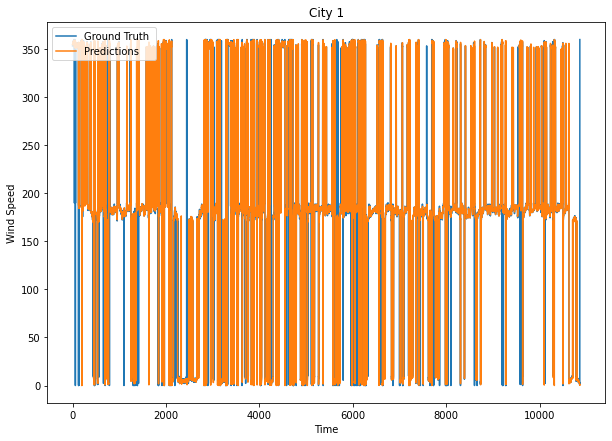

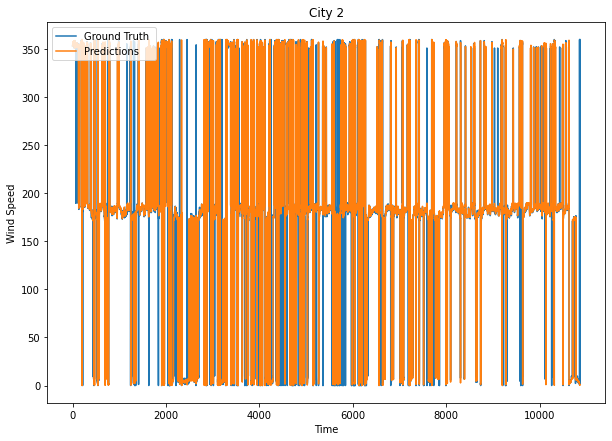

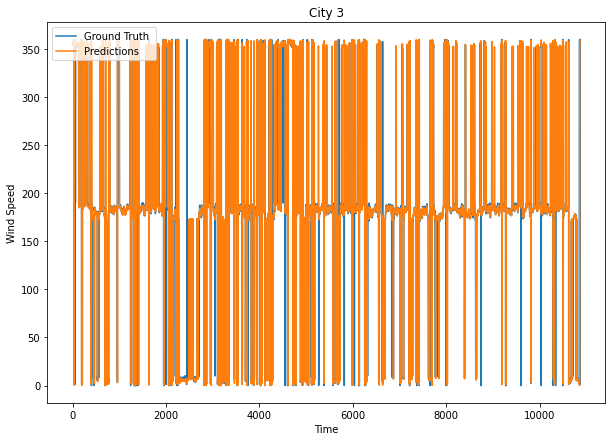

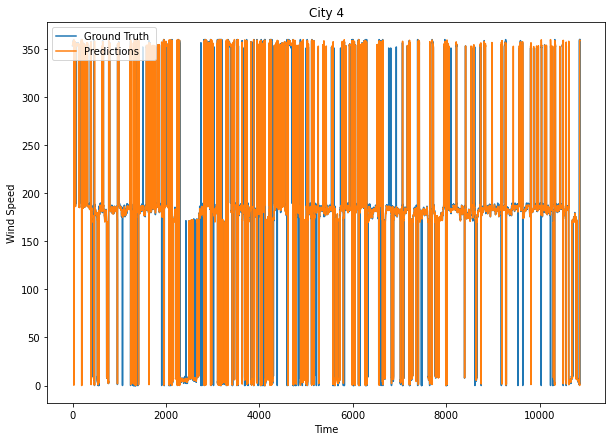

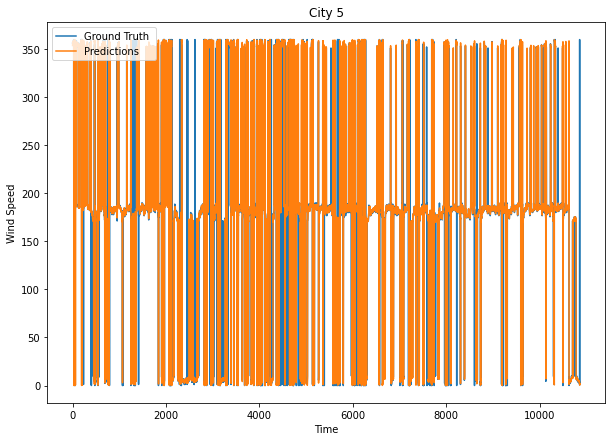

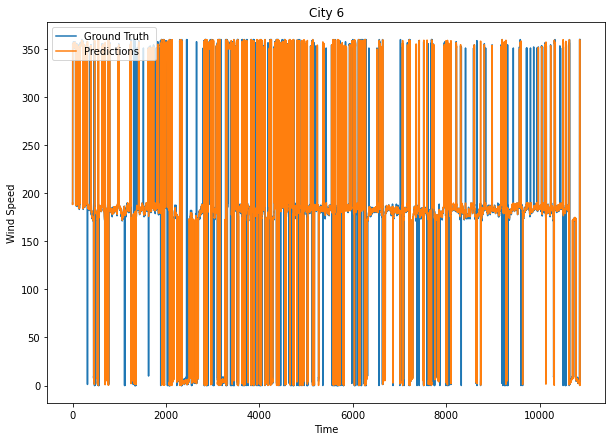

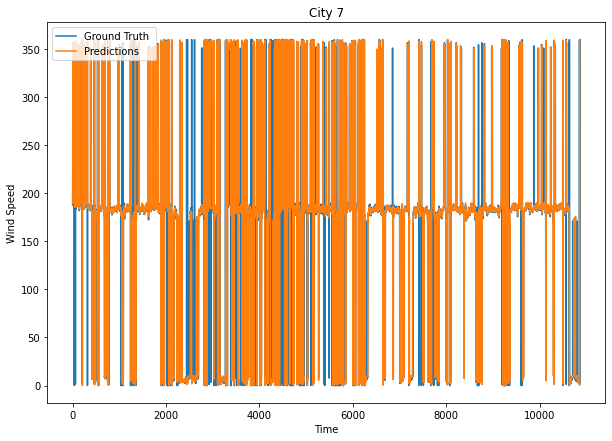

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

def results(y_true, y_preds, plots=True):
    """Visualization of windspeed predictions vs ground truth and
    Overall evaluation the predictions of the test data"""
    
    print('RMSE: ', np.sqrt(mean_squared_error(y_true.flatten(), y_preds.flatten())))
    print('MAE: ', mean_absolute_error(y_true.flatten(), y_preds.flatten()))

    if plots:
        for i in range(7):
            plt.figure(figsize=(10,7))
            plt.plot(range(len(y_true[:, i])), y_true[:, i], label='Ground Truth ')
            plt.plot(range(len(y_preds[:, i])), y_preds[:, i], label='Predictions')
            plt.title('City '+str(i+1))
            plt.xlabel('Time')
            plt.ylabel('Wind Speed')
            plt.legend(loc="upper left")
            plt.show()
        
results(y_true, y_preds, plots=True)

Taking only the first 500 observations

RMSE:  68.04017126164204
MAE:  20.652608620773464


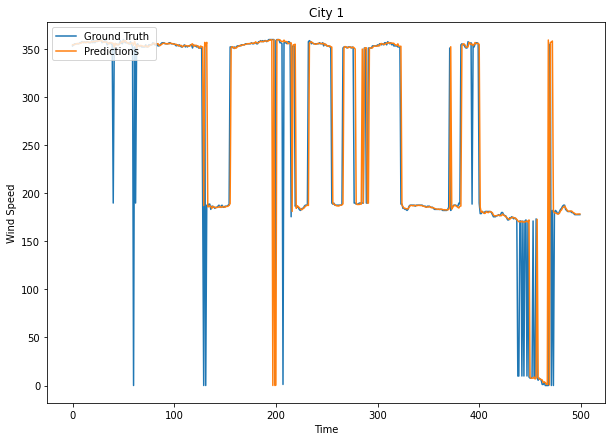

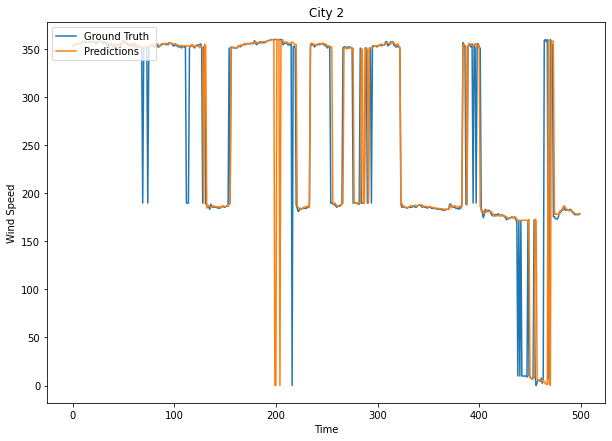

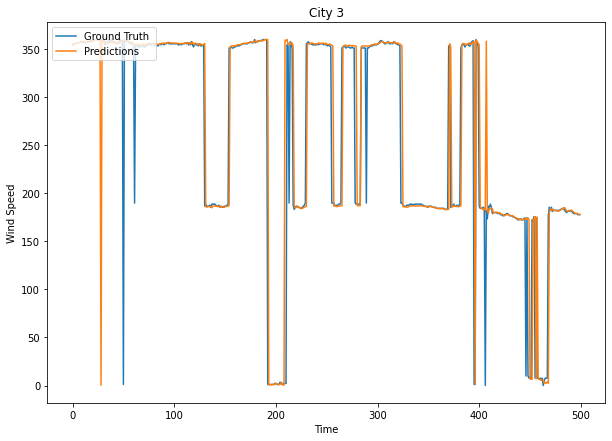

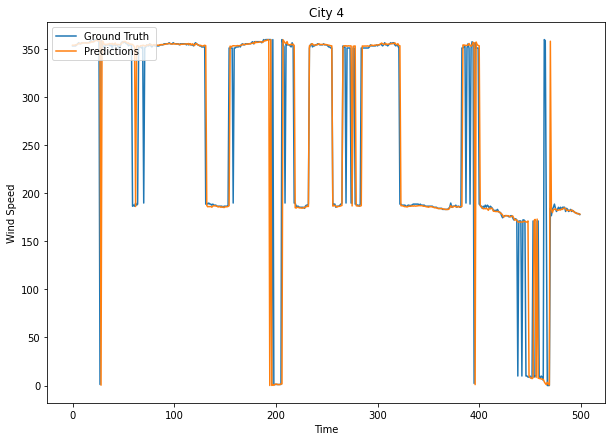

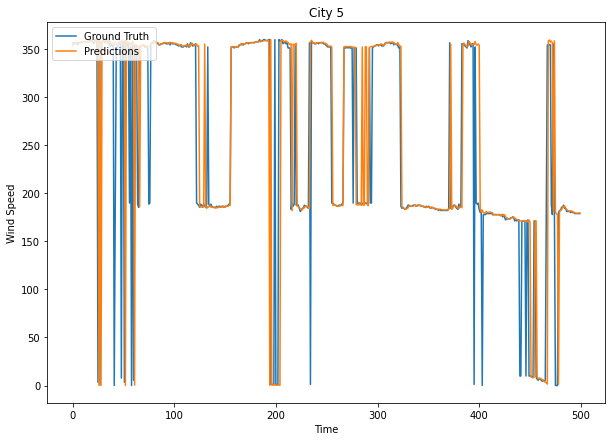

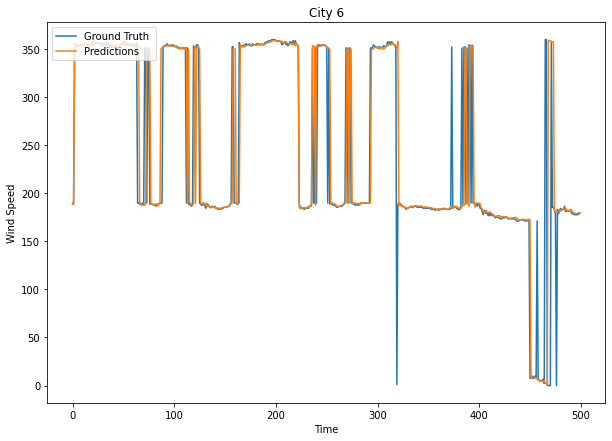

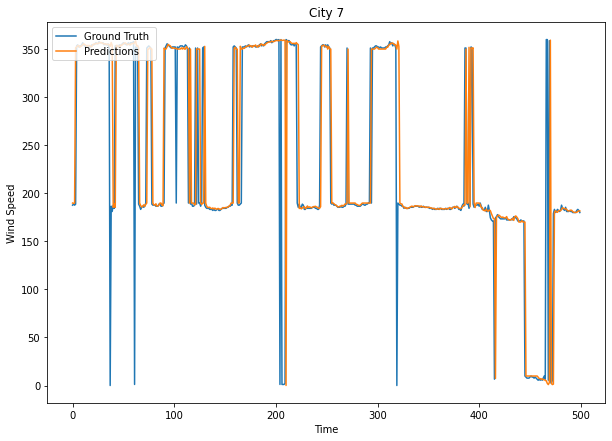

In [13]:
results(y_true[:500], y_preds[:500], plots=True)

# 5 time steps Gap

In [14]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=5)
xtest, ytest = make_ready_data(test_data, train=False, gap=5)
train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, ytrain, yval, ytest)

lstm_model = LSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
lstm_model = run_train(lstm_model)

y_true, y_preds = run_test(lstm_model)
print('Test Data:')
results(y_true, y_preds, plots=False)

Epoch:  1 , Train Loss:  0.09362900405079126 , Val Loss:  0.08629521
Epoch:  6 , Train Loss:  0.08116634450679024 , Val Loss:  0.08363424
Epoch:  11 , Train Loss:  0.07979516672876974 , Val Loss:  0.08306079
Epoch:  16 , Train Loss:  0.0792074092918386 , Val Loss:  0.082299024
Epoch:  21 , Train Loss:  0.07884579919402798 , Val Loss:  0.08186968
Epoch:  26 , Train Loss:  0.07863312366741398 , Val Loss:  0.08180204
Epoch:  31 , Train Loss:  0.07847086099907756 , Val Loss:  0.081724934
Epoch:  36 , Train Loss:  0.07833542292999725 , Val Loss:  0.08164036
Epoch:  41 , Train Loss:  0.07827218745512267 , Val Loss:  0.082033195
Epoch:  46 , Train Loss:  0.07826572580871483 , Val Loss:  0.081559666
Test Data:
RMSE:  75.28232725894405
MAE:  24.36071978784343


# 10 time steps Gap

In [15]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=10)
xtest, ytest = make_ready_data(test_data, train=False, gap=10)
train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, ytrain, yval, ytest)

lstm_model = LSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
lstm_model = run_train(lstm_model)

y_true, y_preds = run_test(lstm_model)

print('Test Data:')
results(y_true, y_preds, plots=False)

Epoch:  1 , Train Loss:  0.09262172692790628 , Val Loss:  0.08850518
Epoch:  6 , Train Loss:  0.08071515339240432 , Val Loss:  0.08385789
Epoch:  11 , Train Loss:  0.07964661741356055 , Val Loss:  0.0833529
Epoch:  16 , Train Loss:  0.07908635922744871 , Val Loss:  0.08314161
Epoch:  21 , Train Loss:  0.07876232808753848 , Val Loss:  0.08295003
Epoch:  26 , Train Loss:  0.07856282674819232 , Val Loss:  0.082682535
Epoch:  31 , Train Loss:  0.07840106567665935 , Val Loss:  0.08256735
Epoch:  36 , Train Loss:  0.07825815502405166 , Val Loss:  0.08245512
Epoch:  41 , Train Loss:  0.07814799826145172 , Val Loss:  0.0824647
Epoch:  46 , Train Loss:  0.07805878679503997 , Val Loss:  0.082560815
Test Data:
RMSE:  76.64329359484728
MAE:  25.21942007950323


# 50 time steps Gap

In [16]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, gap=50)
xtest, ytest = make_ready_data(test_data, train=False, gap=50)
train_iter, val_iter, test_iter = build_dl(xtrain, xval, xtest, ytrain, yval, ytest)

lstm_model = LSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
lstm_model = run_train(lstm_model)

y_true, y_preds = run_test(lstm_model)

print('Test Data:')
results(y_true, y_preds, plots=False)

Epoch:  1 , Train Loss:  0.0932272165166835 , Val Loss:  0.08565434
Epoch:  6 , Train Loss:  0.08055777043675383 , Val Loss:  0.082064286
Epoch:  11 , Train Loss:  0.07962905654584368 , Val Loss:  0.08183231
Epoch:  16 , Train Loss:  0.07909403505896528 , Val Loss:  0.08195714
Epoch:  21 , Train Loss:  0.07875933218648036 , Val Loss:  0.08163509
Epoch:  26 , Train Loss:  0.07855058947826425 , Val Loss:  0.081345625
Epoch:  31 , Train Loss:  0.07840617524484793 , Val Loss:  0.08143176
Epoch:  36 , Train Loss:  0.07832628149017691 , Val Loss:  0.081463896
Epoch:  41 , Train Loss:  0.07823348297774792 , Val Loss:  0.08138666
Epoch:  46 , Train Loss:  0.07815320116182169 , Val Loss:  0.08146863
Test Data:
RMSE:  76.74994333750584
MAE:  25.22769072831235
